<a href="https://colab.research.google.com/github/Aj0625/Sales_Forecasting/blob/main/Sales_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import files
uploaded = files.upload()


Saving Salesforecasting.xlsx to Salesforecasting.xlsx


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [38]:
data = pd.read_excel('/content/Salesforecasting.xlsx')
data


,Warehouse id,Region,SKU id,2018-04-01 00:00:00,2018-05-01 00:00:00,2018-06-01 00:00:00,2018-07-01 00:00:00,2018-08-01 00:00:00,2018-09-01 00:00:00,2018-10-01 00:00:00,...,2020-08-01 00:00:00,2020-09-01 00:00:00,2020-10-01 00:00:00,2020-11-01 00:00:00,2020-12-01 00:00:00,2021-01-01 00:00:00,2021-02-01 00:00:00,2021-03-01 00:00:00,2021-04-01 00:00:00,2021-05-01 00:00:00
0,Wh-1,NORTH,SKU-1,27,13,30,14,22,8,8,...,12,8,8,8,8,8,14,16,8,12
1,Wh-1,NORTH,SKU-2,88,28,127,130,58,10,7,...,16,7,7,7,7,7,13,43,13,43
2,Wh-1,NORTH,SKU-3,6,6,6,6,6,6,6,...,8,6,6,6,6,6,6,8,26,6
3,Wh-1,NORTH,SKU-4,162,184,110,172,90,40,18,...,82,78,38,18,22,28,36,352,58,18
4,Wh-1,NORTH,SKU-5,171,402,627,615,300,417,141,...,468,216,75,6,30,66,141,699,183,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034,Wh-4,SOUTH,SKU-229,7,7,7,7,7,7,7,...,591,167,455,215,135,239,295,7,7,135
1035,Wh-4,SOUTH,SKU-230,49,25,41,13,21,53,33,...,9,9,21,133,9,33,9,103,49,9
1036,Wh-4,SOUTH,SKU-231,21,13,13,21,29,21,21,...,13,13,13,13,13,21,13,13,13,13
1037,Wh-4,SOUTH,SKU-232,15,13,13,11,9,11,36,...,9,9,17,13,11,36,21,17,9,9


In [6]:
# Restructure the data
# Melt the dataset to convert time columns into rows
data = pd.melt(data, id_vars=['Warehouse id', 'Region', 'SKU id'], var_name='Date', value_name='Sales')

# Convert 'Date' to datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%b-%y')

# Sort data by SKU id and Date
data = data.sort_values(by=['SKU id', 'Date'])

In [37]:
data

,Warehouse id,Region,SKU id,Date,Sales
0,Wh-1,NORTH,SKU-1,2018-04-01,0.000526
233,Wh-2,EAST,SKU-1,2018-04-01,0.000445
445,Wh-3,WEST,SKU-1,2018-04-01,0.001799
753,Wh-4,SOUTH,SKU-1,2018-04-01,0.002850
1039,Wh-1,NORTH,SKU-1,2018-05-01,0.000243
...,...,...,...,...,...
34385,Wh-1,NORTH,SKU-99,2021-01-01,0.000910
35424,Wh-1,NORTH,SKU-99,2021-02-01,0.000869
36463,Wh-1,NORTH,SKU-99,2021-03-01,0.001112
37502,Wh-1,NORTH,SKU-99,2021-04-01,0.000869


from matplotlib import pyplot as plt
data['Sales'].plot(kind='hist', bins=20, title='Sales')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
data.groupby('Warehouse id').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
data.groupby('Region').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['Sales']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = data.sort_values('Date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Warehouse id')):
  _plot_series(series, series_name, i)
  fig.legend(title='Warehouse id', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('Sales')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['Sales']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = data.sort_values('Date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Region')):
  _plot_series(series, series_name, i)
  fig.legend(title='Region', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('Sales')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Date']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Date'}, axis=1)
              .sort_values('Date', ascending=True))
  xs = counted['Date']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = data.sort_values('Date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Warehouse id')):
  _plot_series(series, series_name, i)
  fig.legend(title='Warehouse id', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Date']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Date'}, axis=1)
              .sort_values('Date', ascending=True))
  xs = counted['Date']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = data.sort_values('Date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Region')):
  _plot_series(series, series_name, i)
  fig.legend(title='Region', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
data['Sales'].plot(kind='line', figsize=(8, 4), title='Sales')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Region'].value_counts()
    for x_label, grp in data.groupby('Warehouse id')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Warehouse id')
_ = plt.ylabel('Region')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(data['Warehouse id'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(data, x='Sales', y='Warehouse id', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(data['Region'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(data, x='Sales', y='Region', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [14]:
# Step 2: Preprocess the data
# Handling missing values
data = data.ffill() # Forward fill for missing values

# Removing duplicates
data = data.drop_duplicates()

# Normalize the sales data
scaler = MinMaxScaler(feature_range=(0, 1))
data['Sales'] = scaler.fit_transform(data[['Sales']])

# Filter data for a single SKU (example: SKU-1)
sku_data = data[data['SKU id'] == 'SKU-1']

In [15]:
# Create sequences for LSTM
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

# Set time steps
time_steps = 10
sales = sku_data['Sales'].values
X, y = create_sequences(sales, time_steps)

# Reshape input for LSTM [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split data into training and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [16]:
# Step 3: Build the LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_steps, 1)))
model.add(Dropout(0.2)) # Adding dropouts to prevent overfitting.
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 275ms/step - loss: 1.1876e-04 - val_loss: 3.4313e-04
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.5419e-04 - val_loss: 8.2771e-05
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.3175e-05 - val_loss: 9.0270e-05
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.0700e-05 - val_loss: 1.2774e-04
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.3550e-05 - val_loss: 9.3164e-05
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.9131e-06 - val_loss: 7.8569e-05
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.5240e-05 - val_loss: 7.5472e-05
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.3407e-06 - val_loss: 9.3785e-05
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.2350e-06 - val_loss: 7.9116e-05
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.8659e-06 - val_loss: 7.4833e-05
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.5898e-06 - val_loss: 7.8469e

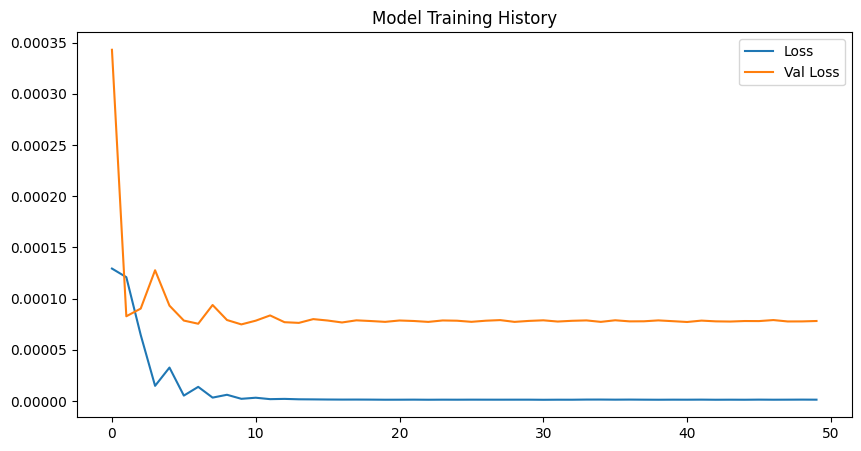

In [20]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Model Training History')
plt.show()

In [34]:
# Step 4: Evaluate the model
predictions = model.predict(X_test)
predictions_rescaled = scaler.inverse_transform(predictions.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculating mape accuracy.
mape = mean_absolute_percentage_error(y_test_actual, predictions_rescaled)
mape


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


2.8580026250509833

In [33]:
predictions_rescaled# Rescale predictions back to original values
predictions_rescaled = scaler.inverse_transform(predictions)

# Round the predictions to the nearest integer
predictions_rounded = np.round(predictions_rescaled).astype(int)

# Convert the predictions back to a DataFrame to match the original structure
predictions_df = pd.DataFrame(predictions_rounded, columns=['Sales'])

# You may need to add the SKU id and Date columns (from the test data) back to the DataFrame
# Assuming X_test has the date information (you can adjust as needed based on your test data)
predictions_df['Date'] = sku_sales.index[-len(predictions_rounded):]  # Adjust this to match the dates of predictions
predictions_df['SKU id'] = 'SKU-1'  # Adjust this for the corresponding SKU id

# Display the predictions in the same format as the original data
print(predictions_df.head())


array([[0.0008759 ],
       [0.00073033],
       [0.00068945],
       [0.00068907],
       [0.00070328],
       [0.00072962],
       [0.00076226],
       [0.00079798],
       [0.00081589],
       [0.00083851],
       [0.00085857],
       [0.00091426],
       [0.00091639],
       [0.00091861],
       [0.00092219],
       [0.00092384],
       [0.00090779],
       [0.00089917],
       [0.00090049],
       [0.00090328],
       [0.0008993 ],
       [0.0008969 ],
       [0.00089967],
       [0.00090469],
       [0.00090459],
       [0.00090099],
       [0.0009072 ],
       [0.00091107],
       [0.0009076 ]], dtype=float32)

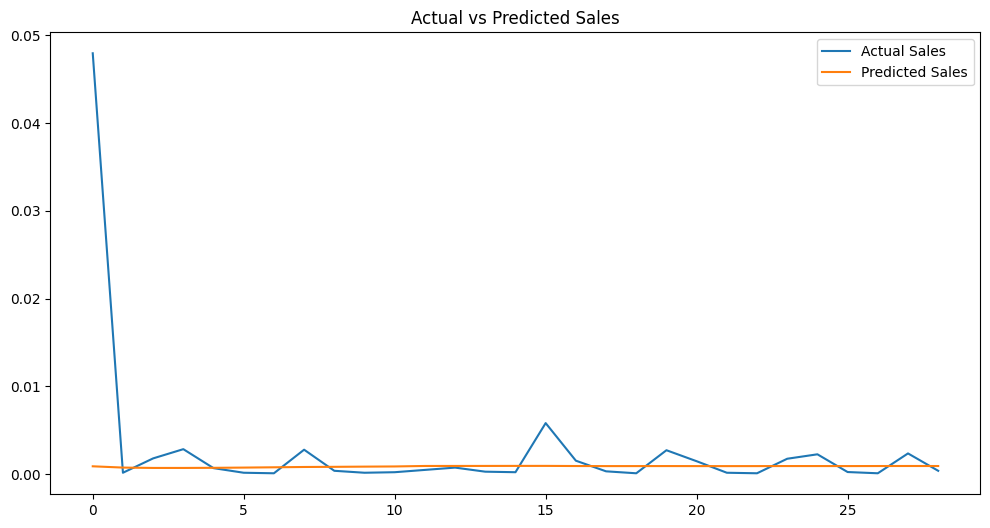

In [35]:
# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Sales')
plt.plot(predictions_rescaled, label='Predicted Sales')
plt.legend()
plt.title('Actual vs Predicted Sales')
plt.show()


In [36]:
# Save the model
model.save('sales_forecasting_model.keras')
